In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [20]:
#df_wos = pd.read_csv("control/ccs_webOfScience.csv", index_col=0, skipinitialspace=True)
#df_sp = pd.read_csv("control/ccs_scopus.csv", index_col=0, skipinitialspace=True)

df_wos = pd.read_csv("../datasets/controls_title_only/webOfScience_fix.csv", skipinitialspace=True)
df_sp = pd.read_csv("../datasets/controls_title_only/scopus_fix.csv", skipinitialspace=True)

In [21]:
df_wos["title"] = df_wos["title"].str.replace('[^\w\d]','', regex=True).str.lower()
df_sp["title"] = df_sp["title"].str.replace('[^\w\d]','', regex=True).str.lower()

df_wos["authors"] = df_wos["authors"].str.lower()
df_sp["authors"] = df_sp["authors"].str.lower()

df_wos["doi"] = df_wos["doi"].str.lower()
df_sp["doi"] = df_sp["doi"].str.lower()

In [22]:
df_doi = df_wos.merge(df_sp, how="inner", on="doi", suffixes=("_wos","_sp"))
df_doi = df_doi[~df_doi["doi"].isnull()]

In [23]:
df_title = df_wos.merge(df_sp, how="inner", on="title", suffixes=("_wos","_sp"))
df_title = df_title[~df_title["title"].isnull()]
df_title["doi_match"] = df_title["doi_wos"] == df_title["doi_sp"]
df_title = df_title[~df_title["doi_match"]]

In [24]:
df_overlap = pd.concat([df_doi.drop(['title_sp','authors_sp','year_sp'], axis=1).rename(columns={'title_wos':'title'}),
                        df_title.drop(['doi_sp','authors_sp','year_sp','doi_match'], axis=1).rename(columns={'doi_wos':'doi'})]).reset_index(drop=True)

In [25]:
df_agg = df_doi.groupby('year_wos').size().rename('doi_matches').reset_index().set_index('year_wos')
df_agg = df_agg.merge(df_title.groupby("year_wos").size().rename('title_matches').reset_index().set_index('year_wos')
                      , on='year_wos', how='outer') \
                .merge(df_wos.groupby('year').size().rename('wos_docs').reset_index().set_index('year')
                      , how='outer', left_index=True, right_index=True) \
                .merge(df_sp.groupby('year').size().rename('sp_docs').reset_index().set_index('year')
                       , how='outer', left_index=True, right_index=True).fillna(0)

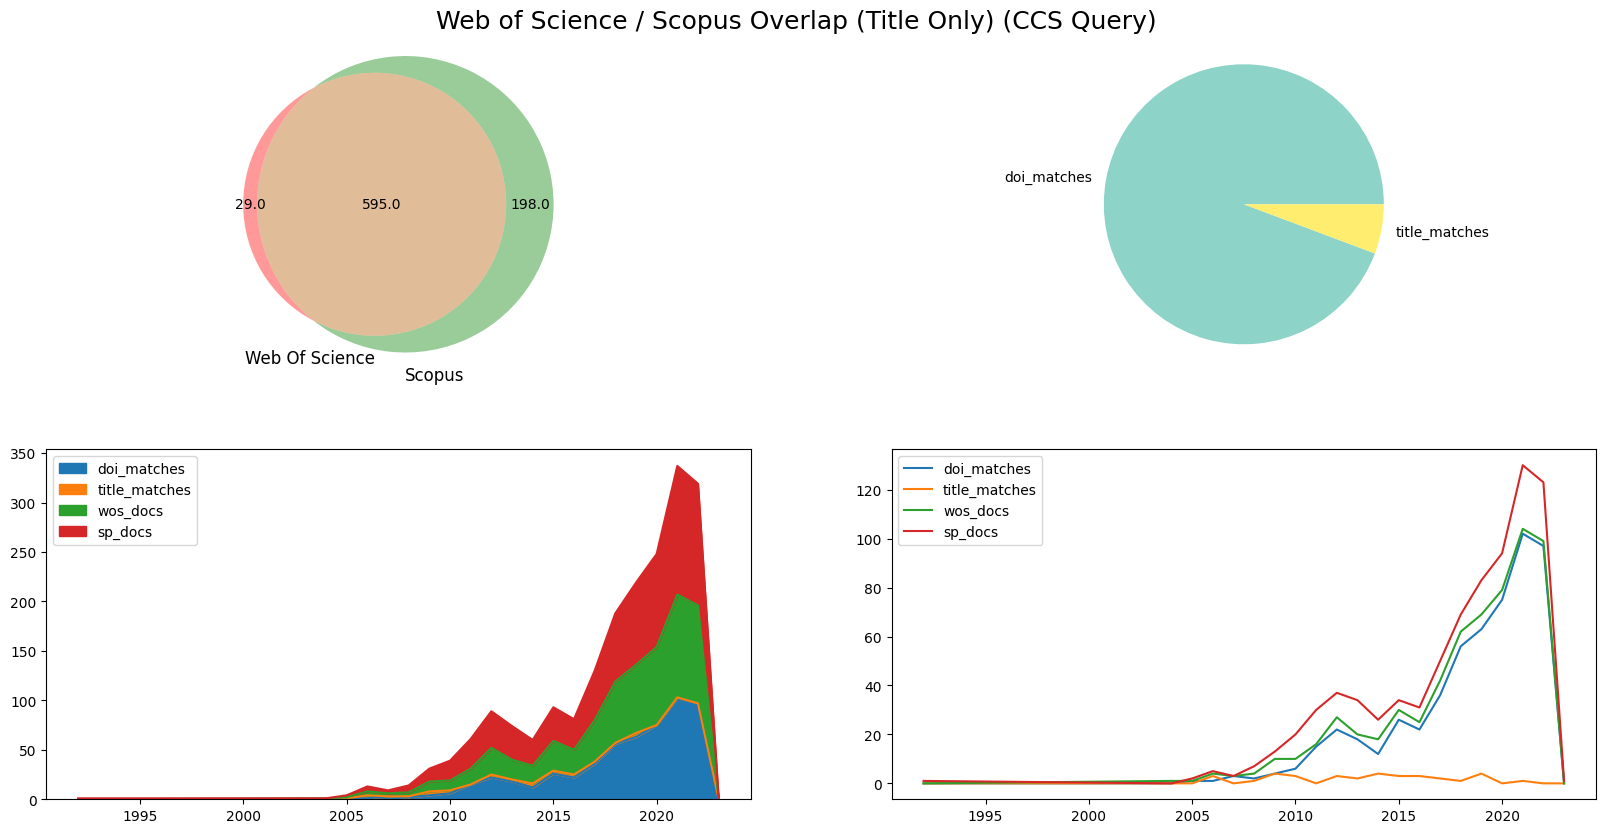

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

matches = df_agg.agg('sum')['doi_matches'] + df_agg.agg('sum')['title_matches']
wos = df_agg.agg('sum')['wos_docs']
sp = df_agg.agg('sum')['sp_docs']

venn2(subsets = (wos - matches,sp - matches,matches), ax=axes[0,0], set_labels=('Web Of Science', 'Scopus', ''))
df_agg[['doi_matches','title_matches']].agg('sum').plot(kind='pie', ax=axes[0,1], colormap='Set3', ylabel="")
df_agg.plot(kind='area', stacked=True, ax=axes[1,0])
df_agg.plot(kind='line', ax=axes[1,1])

plt.suptitle("Web of Science / Scopus Overlap (Title Only) (CCS Query)", fontsize=18, y=0.9)
plt.savefig("/home/joe/repos/mcc/engineEval/db_comparison/local/viz/controls_overlap_title_only.png", bbox_inches="tight")

In [50]:
# Open Alex #

#df_s2 = pd.read_csv('s2_results_nr.tsv', sep='\t')
df_oa = pd.read_csv("/home/joe/Downloads/open_alex_query_results.csv", sep=',')
df_oa["title"] = df_oa["title"].str.replace('[^\w\d]','', regex=True).str.lower()
df_oa["doi"] = df_oa["doi"].str.lower().str.replace('^https:\/\/doi.org\/','', regex=True)

In [51]:
# I removed abstract for the title search

df_oa_doi = df_overlap.merge(df_oa[~df_oa['doi'].isnull()], on='doi', how='inner') \
    .drop(['title_y','authors_wos'], axis=1) \
    .rename(columns={'title_x':'title', 'year_wos' : 'year'})

df_oa_ttl = df_overlap.merge(df_oa[~df_oa['title'].isnull()], on='title', how='inner') \
    .drop(['authors_wos'], axis=1) \
    .rename(columns={'doi_x':'doi', 'year_wos' : 'year'})

df_oa_overlap = pd.concat([df_oa_doi, df_oa_ttl[~(df_oa_ttl['doi'] == df_oa_ttl['doi_y'])].drop(['doi_y'], axis=1)]).reset_index(drop=True)

In [52]:
df_oa_wos_doi = df_wos.merge(df_oa[~df_oa['doi'].isnull()], on='doi', how='inner') \
    .drop(['title_y'], axis=1) \
    .rename(columns={'title_x':'title', 'year_x' : 'year'})

df_oa_wos_ttl = df_wos.merge(df_oa[~df_oa['title'].isnull()], on='title', how='inner') \
    .rename(columns={'doi_x':'doi', 'year_wos' : 'year'})

df_oa_wos = pd.concat([df_oa_wos_doi, df_oa_wos_ttl[~(df_oa_wos_ttl['doi'] == df_oa_wos_ttl['doi_y'])].drop(['doi_y'], axis=1)]).reset_index(drop=True)

In [53]:
df_oa_sp_doi = df_sp.merge(df_oa[~df_oa['doi'].isnull()], on='doi', how='inner') \
    .drop(['title_y'], axis=1) \
    .rename(columns={'title_x':'title', 'year_x' : 'year'})

df_oa_sp_ttl = df_sp.merge(df_oa[~df_oa['title'].isnull()], on='title', how='inner') \
    .rename(columns={'doi_x':'doi', 'year_wos' : 'year'})

df_oa_sp = pd.concat([df_oa_sp_doi, df_oa_sp_ttl[~(df_oa_sp_ttl['doi'] == df_oa_sp_ttl['doi_y'])].drop(['doi_y'], axis=1)]).reset_index(drop=True)

In [54]:
df_oa_agg = df_oa_overlap.groupby('year').size().rename('overlapped_matches').reset_index().set_index('year')
df_oa_agg = df_oa_agg.merge(df_oa_wos.groupby("year").size().rename('wos_matches').reset_index().set_index('year')
                      , on='year', how='outer') \
                .merge(df_oa_sp.groupby('year').size().rename('sp_matches').reset_index().set_index('year')
                       , on='year', how='outer') \
                .merge(df_wos.groupby('year').size().rename('wos_docs').reset_index().set_index('year')
                      , how='outer', left_index=True, right_index=True) \
                .merge(df_sp.groupby('year').size().rename('sp_docs').reset_index().set_index('year')
                       , how='outer' , left_index=True, right_index=True) \
                .merge(df_oa.rename(columns={'publication_year' : 'year'}).groupby('year').size().rename('oa_docs').reset_index().set_index('year')
                       , on='year', how='outer') \
                       .fillna(0)

<AxesSubplot:xlabel='year'>

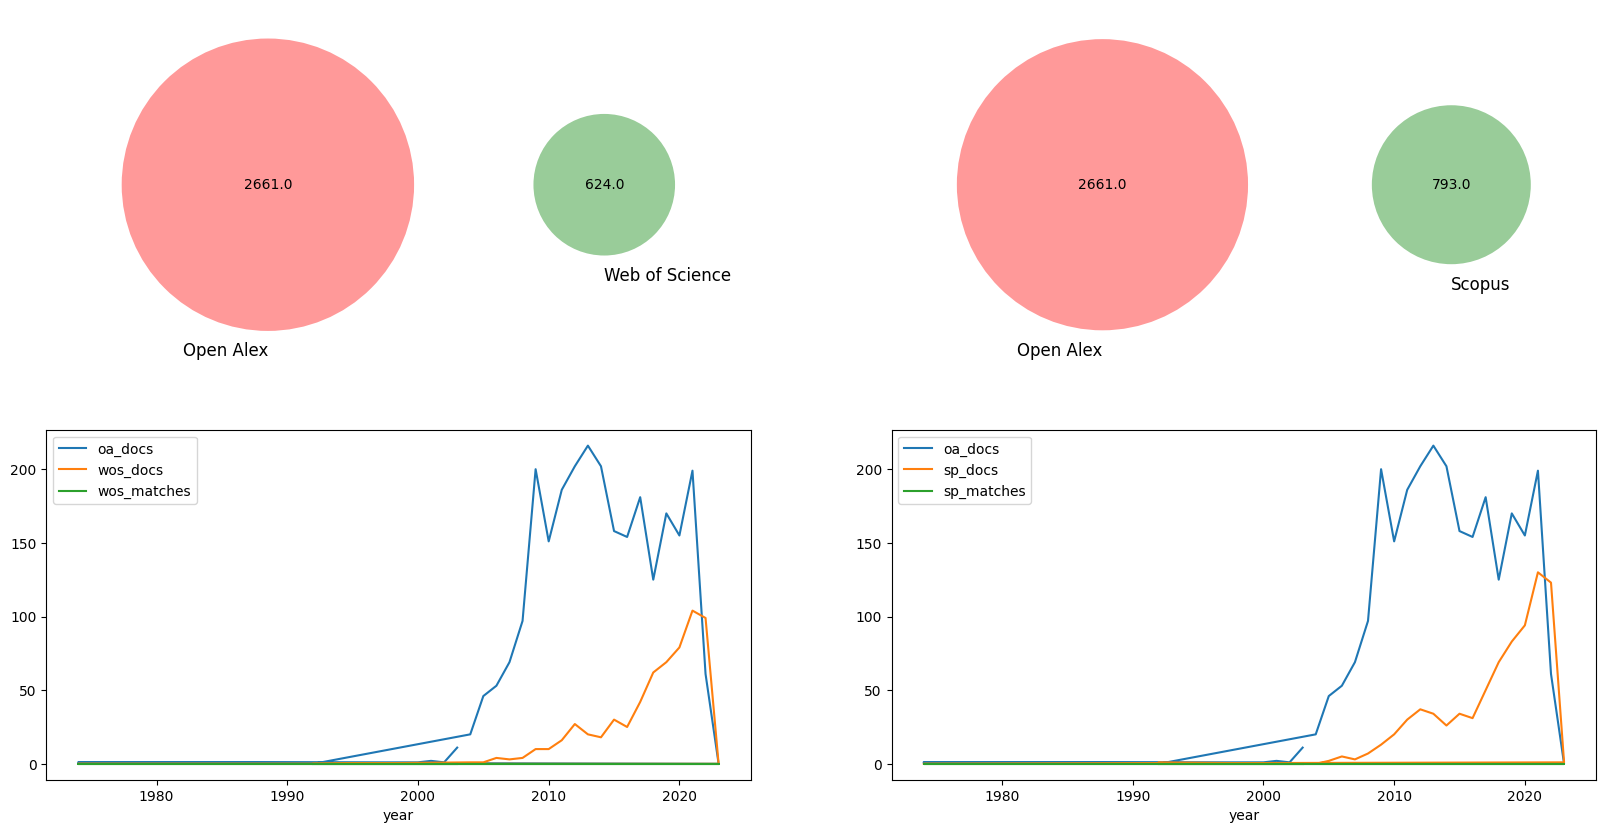

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

oa_wos_matches = df_oa_agg.agg('sum')['wos_matches']
oa_sp_matches = df_oa_agg.agg('sum')['sp_matches']
oa_overlap_matches = df_oa_agg.agg('sum')['overlapped_matches']
wos = df_oa_agg.agg('sum')['wos_docs']
oa = df_oa_agg.agg('sum')['oa_docs']
sp = df_oa_agg.agg('sum')['sp_docs']

venn2(subsets = (oa,wos,oa_wos_matches), ax=axes[0,0], set_labels=('Open Alex', 'Web of Science', ''))
venn2(subsets = (oa,sp,oa_sp_matches), ax=axes[0,1], set_labels=('Open Alex', 'Scopus'))

df_oa_agg[['oa_docs','wos_docs','wos_matches']].plot(kind='line', ax=axes[1,0])
df_oa_agg[['oa_docs','sp_docs','sp_matches']].plot(kind='line', ax=axes[1,1,])

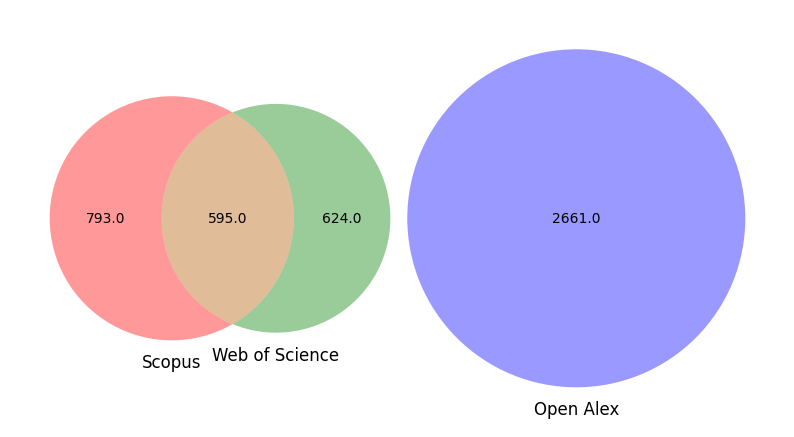

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

venn3(subsets = (sp
                 , wos
                 , matches - oa_overlap_matches
                 , oa 
                 , oa_sp_matches - oa_overlap_matches
                 , oa_wos_matches - oa_overlap_matches
                 , oa_overlap_matches
                ), set_labels = ('Scopus', 'Web of Science', 'Open Alex'), ax=axes)

In [66]:
df_sp.groupby(df_sp["doi"].isnull()).size()

# Using SQL -- of the 703 Scopus DOI Values, 644 Are in Open Alex

doi
False    703
True      90
dtype: int64

In [68]:
df_wos.groupby(df_wos["doi"].isnull()).size()

# Using SQL -- of the 592 Web of Science Values, 558 are in Open Alex

doi
False    592
True      49
dtype: int64

In [ ]:
for val in df_wos.loc[~df_wos["doi"].isnull()]["doi"]:
    print(f", 'https://doi.org/{val}'")

In [76]:
all_ctrl_dois = pd.concat([df_sp["doi"],df_wos["doi"]]).unique()

In [ ]:
for val in all_ctrl_dois:
    print(f", '{val}'")
    
# For 719 Distinct DOIS, openalex has 658 and s2 has 154, 665 in total which is 92.5% Coverage
# "dataset"	"doi"
# "openalex"	"511"
# "openalex,s2"	"147"
# "s2"	"7"